Why DIRECT? in this paper, the threats have been simplified to circular boundaries. In real life, the boundaries will be irregular, and will have no explicit differentiable expression avalible.

In [106]:
from scipy.optimize import direct
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

s# Deriving the cost function.

## Finding an initial cost function

* Consider problem in two dimensions.
* Route consists of start and endpoints with a number of intermediate waypoints.
* The coordinates of the waypoints are the optimization variables.
* We want the distance flown to be minimal, so calculate Euclidian distance of the route, and label it $L$.
* Determine if any of our path lies within a threat, and the length of the path within the threat.

If the route lies within the $i$-th threat for a distance $L_i$ then the cost of the route can be expressed as

$C = L + \displaystyle\sum_{i} \rho _i L_{i}^{rho}$

$\rho _i$ is a penalty parameter for the $i$-th threat.

In other words, the cost is the total length of the path, plus the length of each segment within a threat multiplied by the penalty parameter associated with that particular threat.

## Defining "leg" length
We have $n$ waypoints $w_j = (w_{j1}, w_{j2})$ for $j = 1, ..., n$, let the start and end points be $w_0, w_{n+1}$ respectively. We can define the vector $u_j = w_j - w_{j-1}$ which helps us defined the length of any given leg as 

$l_j = \sqrt{(u_{j1}^2 + u_{j2}^2)}$

## Determining threat violations

We  will use linear interpoliation to estimate where leg $j$ intersects with threat $i$. 

Consider $\sigma _{max}$ to be the maximum step size for use in sampling any leg of a route. This means that the number of samplings points along leg $j$ is $K_{max} = \lceil l_j / \sigma _{max} \rceil$.Let the normalized step size be $\delta \lambda = \frac{1}{K_{max}}$ and let $u_k$ be a sampled point in the leg.

$u_k = w_{j-1} + k \delta \lambda (w_j - w_{j-1})$

$k = [0, ..., K_{max}]$.

Suppose we have an indicator function of position, $T_i$, such that $T_i(u_k) \leq 0$ indicates that the sampled position within the leg, $u_k$ is within threat i, and confirms that the position is not within the threat otherwise. Using what we have defined so far can create an algorithm for calculating "in threat" length, denoted $l_{ji}$.

1. Find $l_j$, $l_i$. Set $i_{ji} = 0$  
2. Set $k=0$, $K_{max}=(\delta \lambda)^{-1}$  
3. If $T_i (u_0) \leq 0$ then $\lambda _b = 0$  
4. For $k = 1, ..., K_{max}$   
5.  ---> If $T_i (u_k) \leq 0$ and $T_i (u_{k-1}) > 0$ then  
6.  ------->  set $\kappa = T_i(u_k)/(T_i(u_k)-T_i(u_{k-1})), \lambda _b = (k - \kappa)\delta \lambda$  
7.  ---> If $T_i (u_k) > 0$ and $T_i (u_{k-1}) \leq 0$ then  
8.  ------->  set $\kappa = T_i(u_k)/(T_i(u_k)-T_i(u_{k-1})), \lambda _e = (k - \kappa)\delta \lambda$  
9.  ------->  set $l_{ji} + (\lambda _e - \lambda _b) l_j$  
10.  ---> If $T_i (u_{K_{max}}) \leq 0$ then   
11.  -------> set $l_{ji} = l_{ji} + (1- \lambda _b )l_j$  

Line-by-line explanation:

1. Find the length of the current leg. Initialize "in threat" distance accumulator as 0.
2. Set up a counter at 0, and set $K_{max} = (\delta \lambda)^{-1}$. Recall: $\delta \lambda = 1/K_{max}$. So we're just initializing $K_{max}$ with it's own value.
3. Determine if our starting point is within the threat.
4. For k = 1 -> $K_{max}$ to start checking each point along the leg.
5. Detect if the path passed INTO the threat.
6. Calculate the location of the boundary with interpolation. $\kappa$ is the fractional interpolation value, it represents a number from 0-1 that says where the boundary crossing lies between two samples on the leg. After that, we calculate where the crossing occurs on the entire leg. We know the crossing occured when we took the k-th step. So $k-\kappa$ is the number of steps to where the boundary is, and $\delta \lambda$ is our step size.
7. Detect if the passed passed OUT of the threat
8. Perform the same interpolation as step 6. Set $\lambda _e$ instead which is the exit position.
9. Since we've exited, we can calculate the in-threat distance, $l_{ji}$. $(\lambda _e - \lambda _b)$ represents the normalized distance in the threat zone and multiplying it by $l_j$ converts it to real distance. Add it to the accumulator. 
10. Determine if exit point is inside the threat
11. Do a similar calculation to step 9, add it to the accumulator.
 
## Defining constraints
Two additional features are included to enhance the realism of the simulation. Firstly, you can restrict routes that involve sharp turns, and secondly, you can set a limit on the distance between waypoints.

The angle between successive legs is defined as $\phi _j$. Given by

$\phi _j = cos^{-1}\{\frac{u_j ^T u_{j+1}}{||u_j|| ||u_{j+1}||}\}$

$\phi _{max}$ is the limiting turn angle, and $l_{min}$ is the minimum leg-length. We can define a final extended cost function.

$$
C = \sum_{j=1}^{n+1} ( l_j + \mu (( l_{min} - l_j )_+ )^2 + \sum_{j=1}^m \rho _i l_{ji}^rho ) + \sum_{j=1}^n v ((\phi _j - \phi _{max})_+)^2
$$

$\mu$ and $v$ are positive penalty parameters for controling minimum leg length and turn angle.

## Helper functions

In [107]:
def T_i(point: np.ndarray, center: np.ndarray, radius: int) -> float:
    """Calculate the distance from a point to the threat zone, negative value indicates inside the zone"""
    return np.linalg.norm(point - center) - radius

def in_threat_distance(start: np.ndarray, end: np.ndarray, center: np.ndarray, radius: int, sigma_max: int) -> float:  
    """Calculate the in-threat distance of a leg"""

    l_j = np.linalg.norm(end - start) # Magnitude of the leg vector
    if l_j == 0: # Check if leg-length is zero
        return 0 
    l_ji = 0.0  # initialize in-threat distance accumulator
    K_max = int(np.ceil(l_j / sigma_max))  # The total number of samples along the leg
    delta_lambda = 1 / K_max # Step size

    # If the starting point is inside the threat zone, set lambda_b to 0
    if T_i(start, center, radius) <= 0:
        lambda_b = 0

    # Loop through each step along the leg
    for k in range(1, K_max+1):
        lambda_k = k * delta_lambda # Current normalized distance along the leg. k = num steps and delta_lambda = normalized step size
        u_k = start + lambda_k * (end - start) # Current point along the leg. lambda_k * (end - start) = Actual point on the leg (not normalized)
        T_k = T_i(u_k, center, radius) # Calculate the distance from the current point to the threat zone

        u_k_prev = start + (lambda_k - delta_lambda) * (end - start) # Previous point along the leg
        T_k_prev = T_i(u_k_prev, center, radius) # Calculate the distance from the previous point to the threat zone

        # Entering threat zone, meaning current point is inside and the previous was outside
        if T_k <= 0 and T_k_prev > 0:
            kappa = T_k / (T_k - T_k_prev) # Ratio of the distance to the threat zone at the current point to the distance at the previous point
            lambda_b = (k - kappa) * delta_lambda # Normalized distance at which the leg enters the threat zone
        
        # Exiting threat zone, meaning the current point is outside and the previous was inside
        if T_k > 0 and T_k_prev <= 0:
            kappa = T_k / (T_k - T_k_prev) # Same as above, but for exiting the zone
            lambda_e = (k - kappa) * delta_lambda # Normalized distance at which the leg exits the threat zone
            l_ji += (lambda_e - lambda_b) * l_j # Accumulate the in-threat distance since we have now exited the zone
            lambda_b = None # Reset lambda_b for the next leg
    
    # If ending inside threat zone
    if T_i(end, center, radius) <= 0 and lambda_b is not None:
        l_ji += (1.0 - lambda_b) * l_j # Accumulate the in-threat distance 
    return l_ji

def calculate_path_length(waypoints: np.ndarray) -> np.float64:
    """Calculate the length of a path defined by waypoints"""
    legs = np.diff(waypoints, axis=0)
    return np.sum(np.linalg.norm(legs, axis=1))

# Cost function

In [108]:
def cost(waypoint_coords: np.ndarray, # Flat representation of waypoints, i.e. (1, 6) and (2, 4) represented as [1, 6, 2, 4]
        start: np.ndarray, # Start point of the path
        end: np.ndarray, # End point of the path
        threats: list, # List of tuples, each containing a threat center and radius. Threat center is a np.ndarray like start and end
        lmin: int, # Minimum leg length
        phi_max: np.float64, # Maximum turn angle in radians
        mu: int, # Penalty for leg length
        nu: int, # Penalty for turn angle
        rho: int, # Penalty for threat distance
        sigma_max=4.0) -> np.float64: # Maximum step size for sampling

    PENALTY_EXPONENT = 3 # Exponent for the in threat distance penalty

    # Get a list of all the waypoints in order.
    # reshape(-1, 2) converts the flat representation into a 2D array of shape (n, 2)
    # vstack puts the start and end points into the correct positions.
    waypoints = np.vstack([start, waypoint_coords.reshape(-1, 2), end]) 

    # Calculate each leg length
    legs = np.diff(waypoints, axis=0) # Get the vector representation of each leg
    leg_lengths = np.linalg.norm(legs, axis=1) # Compute the magnitude of each leg vector

    # Calculate turn angles
    turn_angles = []
    for j in range(1, len(legs)): # Start from the second leg because the first leg has no previous leg to compare to
        dot_product = np.dot(legs[j-1], legs[j]) # Dot product of the two legs
        norm_prev = np.linalg.norm(legs[j-1]) # Magnitude of the previous leg (magnitude = norm = length for vectors)
        norm_curr = np.linalg.norm(legs[j])  # Magnitude of the current leg
        cos_phi = dot_product / (norm_prev * norm_curr) # Normalize the dot product to get the cosine of the angle, Definition of dot product: u⋅v = |u||v|cosθ
        angle = np.arccos(np.clip(cos_phi, -1, 1)) # Use arccos to get the angle from the cosine value. np.clip prevents out-of-bounds errors.
        turn_angles.append(angle)

    #turn_angles = [ np.arccos(np.clip(np.dot(legs[j-1], legs[j]) / (np.linalg.norm(legs[j-1]) * np.linalg.norm(legs[j])), -1, 1)) for j in range(1, len(legs)) ]

    # Calculate total cost
    total_cost = np.sum(leg_lengths) # Total path length
    total_cost += np.sum(mu * np.maximum(lmin - leg_lengths, 0) ** 2) # Leg length penalties
    total_cost += np.sum(nu * np.maximum(turn_angles - phi_max, 0) ** 2) # Turn angle penalties

    # Threat penalties
    for threat_centre, threat_radius in threats:
        # Calculate and sum the in-threat distance of each leg
        l_ji = sum(in_threat_distance(waypoints[j], waypoints[j+1], threat_centre, threat_radius, sigma_max) for j in range(len(legs)))
        total_cost += rho * (l_ji ** PENALTY_EXPONENT)

    return total_cost

In [109]:
def optimize_leg(start: np.ndarray,
                end: np.ndarray,
                threats: list, # List of tuples, each containing a threat center and radius. Threat center is a np.ndarray like start and end
                initial_bounds: np.ndarray, # Initial bounds for the waypoints
                n_waypoints: int, # Number of waypoints to optimize
                lmin: int, # Minimum leg length 
                phi_max: float, # Maximum turn angle in degrees
                mu: int, # Penalty for leg length
                nu: int, # Penalty for turn angle
                rho: int, # Penalty for threat distance
                maxiter=128, # Maximum number of iterations 
                restart=True): # Whether to restart the optimization with a refined search around the best point found
    
    phi_max = np.radians(phi_max)  # Convert to radians
    
    # Set up the bounds
    lb = initial_bounds[:, 0].flatten()
    ub = initial_bounds[:, 1].flatten()

    # Call direct
    result = direct(lambda waypoint_coords: cost(waypoint_coords, start, end, threats, lmin=lmin, phi_max=phi_max, mu=mu, nu=nu, rho=rho),
                   bounds=list(zip(lb, ub)),
                   maxiter=maxiter//2 if restart else maxiter, # Use half the max iterations for the first run if restarting
                   locally_biased=True)  
    
    # Call direct with refined boundaries
    if restart:
        refined_lb = result.x - np.array([5, 5]*n_waypoints) 
        refined_ub = result.x + np.array([5, 5]*n_waypoints)
        result = direct(lambda x: cost(x, start, end, threats, lmin=lmin, phi_max=phi_max, mu=mu, nu=nu, rho=rho),
                       bounds=list(zip(refined_lb, refined_ub)),
                       maxiter=maxiter//2,
                       locally_biased=True)
    
    return result.x.reshape(-1, 2), result.fun

## Approach #1 - Separate calculation of outward and return legs.
First we're going to assume two waypoints will be sufficient. Place them at a point along the midline, paper uses (108 ± 60, 68 ± 40), (109 ± 60, 69 ± 40). Additionally we're using parameters µ = ν = ρ_i = 1.

In [ ]:
threats = [ 
    (np.array([75,  29]),    9),    
    (np.array([80,  66]),    15),   
    (np.array([95,  115]),   22.5), 
    (np.array([135, 131]),   20),   
    (np.array([140, 67.5]),  37.5), 
    (np.array([197, 125]),   30)    
] 

origin = np.array([50, 30])
destination = np.array([167, 107])

initial_bounds = np.array([ # Initial bounds from the paper.
    [[108 - 60, 108 + 60], [68 - 40, 68 + 40]],
    [[109 - 60, 109 + 60], [69 - 40, 69 + 40]]
]).transpose(0, 2, 1)

print("=== Optimizing Outbound Leg ===")
out_waypoints, out_cost = optimize_leg(
    origin, 
    destination, 
    threats, 
    initial_bounds,
    n_waypoints=2, 
    maxiter=64,
    lmin=10,
    phi_max=42.5,
    mu=1, 
    nu=1, 
    rho=1,
    restart=True
)

outbound_path = np.vstack([origin, out_waypoints, destination])
outbound_length = calculate_path_length(outbound_path)
print(f"Outbound path length: {outbound_length:.2f} km")
print(f"Outbound cost: {out_cost:.2f}")  
print(f"\nOutbound waypoints:")
for i in out_waypoints:
    print(f"  {i}")


=== Optimizing Outbound Leg ===
Outbound path length: 155.22 km
Outbound cost: 155.22

Outbound waypoints:
  [68.29263832 77.0260631 ]
  [127.19387289 104.16384697]


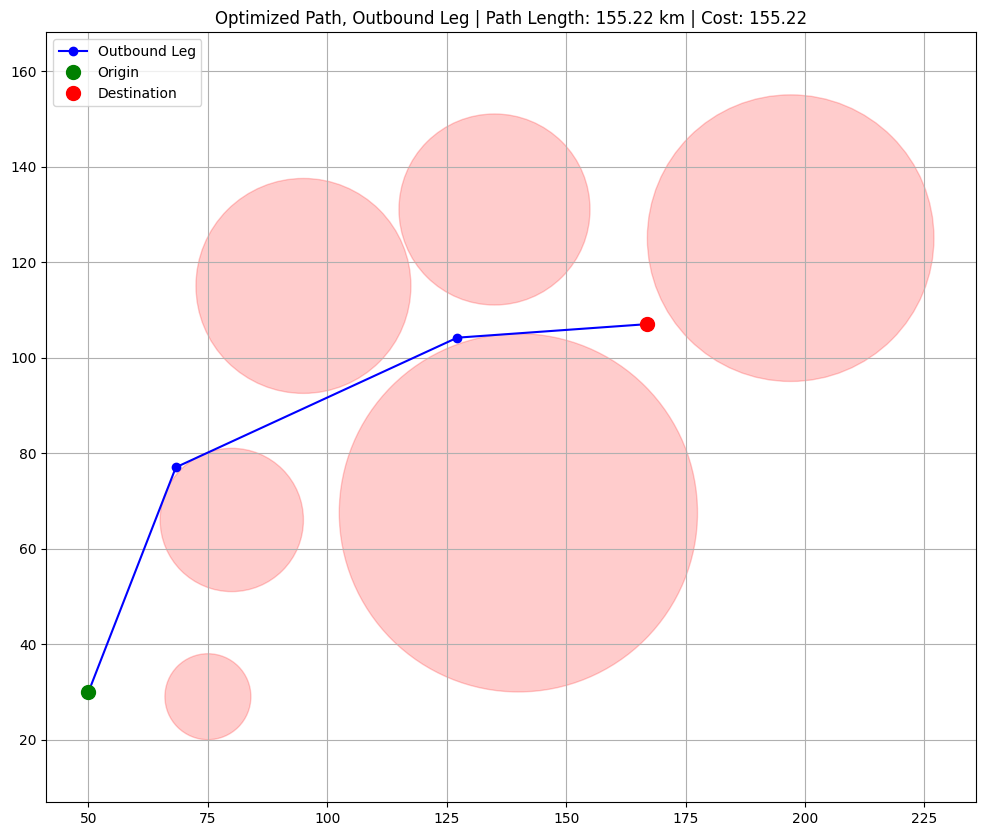

In [ ]:
# Visualization for outbound leg
plt.figure(figsize=(12, 10))

# outbound leg
plt.plot(
    np.vstack([origin, out_waypoints, destination])[:, 0],
    np.vstack([origin, out_waypoints, destination])[:, 1],
    'b-o', 
    label='Outbound Leg'
)

plt.plot(origin[0], origin[1], 'go', markersize=10, label='Origin')
plt.plot(destination[0], destination[1], 'ro', markersize=10, label='Destination')

for center, radius in threats:
    plt.gca().add_patch(Circle(center, radius, color='r', alpha=0.2))
plt.axis('equal')
plt.grid()
plt.legend()
plt.title(f"Optimized Path, Outbound Leg | Path Length: {outbound_length:.2f} km | Cost: {out_cost:.2f}")
plt.show()
